# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [128]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(float(loss_sum / num_batches))

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [129]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [130]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [131]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.452
adam: Epoch 4 Loss 0.287
adam: Epoch 6 Loss 0.244
adam: Epoch 8 Loss 0.223
adam: Epoch 10 Loss 0.207
adam: Epoch 12 Loss 0.194
adam: Epoch 14 Loss 0.189
adam: Epoch 16 Loss 0.186
adam: Epoch 18 Loss 0.178
adam: Epoch 20 Loss 0.171


Text(0.5, 1.0, 'MNIST')

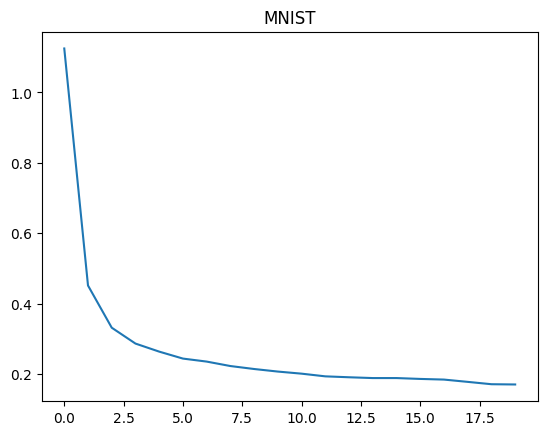

In [139]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [133]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [134]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 92.41


,0,1,2,3,4,5,6,7,8,9
0,96.632653,0.000000,0.408163,0.510204,0.510204,0.918367,0.306122,0.102041,0.612245,0.000000
1,0.088106,97.797357,0.881057,0.264317,0.176211,0.088106,0.088106,0.528634,0.088106,0.000000
2,1.065891,0.000000,93.895349,1.841085,0.000000,0.000000,0.872093,1.162791,1.065891,0.096899
3,1.386139,0.792079,3.267327,88.514851,0.099010,2.871287,0.297030,1.386139,0.891089,0.495050
4,0.101833,0.610998,0.509165,0.000000,93.279022,0.000000,1.527495,0.305499,0.407332,3.258656
5,0.672646,0.560538,0.224215,4.035874,0.112108,88.228700,0.784753,0.336323,3.139013,1.905830
6,0.417537,0.208768,1.356994,0.417537,0.835073,1.774530,94.050104,0.000000,0.939457,0.000000
7,0.291829,1.264591,2.626459,0.389105,0.486381,0.000000,0.000000,92.704280,0.097276,2.140078
8,1.437372,0.102669,2.258727,0.924025,0.616016,2.258727,2.977413,2.053388,85.934292,1.437372
9,1.090188,0.198216,0.099108,0.099108,2.675917,1.189296,0.198216,2.180377,0.396432,91.873142


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [191]:
results1 = []

### 1. CNN2D Nets with 1, 2, or 3 convolutional layers, each with 10 units and patch sizes of 1 and strides of 1

In [158]:
# Train CNN2D with 1 convolutional layer
cnnet1 = CNN2D(28 * 28, [10], [5], len(np.unique(Ttrain)), [5], [1], device=device)
cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.747
adam: Epoch 4 Loss 0.605
adam: Epoch 6 Loss 0.524
adam: Epoch 8 Loss 0.487
adam: Epoch 10 Loss 0.449
adam: Epoch 12 Loss 0.416
adam: Epoch 14 Loss 0.393
adam: Epoch 16 Loss 0.386
adam: Epoch 18 Loss 0.354
adam: Epoch 20 Loss 0.359


In [192]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet1.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 1: {train_perc_correct:.2f}')

Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 1: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10]", "FC Arch": "[5]", "Parch Arch": "[5]", "Stride Arch": "[1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 1: 89.39
Test accuracy in percent correct for CNN 1: 90.12


In [161]:
# Train CNN2D with 2 convolutional layers
cnnet2 = CNN2D(28 * 28, [10, 10], [5], len(np.unique(Ttrain)), [5, 5], [1, 1], device=device)
cnnet2.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.738
adam: Epoch 4 Loss 0.542
adam: Epoch 6 Loss 0.451
adam: Epoch 8 Loss 0.402
adam: Epoch 10 Loss 0.355
adam: Epoch 12 Loss 0.323
adam: Epoch 14 Loss 0.316
adam: Epoch 16 Loss 0.308
adam: Epoch 18 Loss 0.294
adam: Epoch 20 Loss 0.272


In [193]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet2.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 2: {train_perc_correct:.2f}')

Classes, _ = cnnet2.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 2: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10]", "FC Arch": "[5]", "Parch Arch": "[5, 5]", "Stride Arch": "[1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 2: 93.75
Test accuracy in percent correct for CNN 2: 93.95


In [164]:
# Train CNN2D with 3 convolutional layers
cnnet3 = CNN2D(28 * 28, [10, 10, 10], [5], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet3.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.626
adam: Epoch 4 Loss 0.434
adam: Epoch 6 Loss 0.368
adam: Epoch 8 Loss 0.372
adam: Epoch 10 Loss 0.350
adam: Epoch 12 Loss 0.333
adam: Epoch 14 Loss 0.303
adam: Epoch 16 Loss 0.304
adam: Epoch 18 Loss 0.289
adam: Epoch 20 Loss 0.297


In [194]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet3.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 3: {train_perc_correct:.2f}')

Classes, _ = cnnet3.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 3: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[5]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 3: 93.03
Test accuracy in percent correct for CNN 3: 93.98


### 2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.
The best performing model from those above was the one with 3 convolutional layers, so using that going forward

In [ ]:
# Train CNN2D with 0 FC Layers
cnnet4 = CNN2D(28 * 28, [10, 10, 10], [], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet4.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 2 Loss 0.185
adam: Epoch 4 Loss 0.173
adam: Epoch 6 Loss 0.155
adam: Epoch 8 Loss 0.128
adam: Epoch 10 Loss 0.112
adam: Epoch 12 Loss 0.088
adam: Epoch 14 Loss 0.105
adam: Epoch 16 Loss 0.083
adam: Epoch 18 Loss 0.084
adam: Epoch 20 Loss 0.078
Test accuracy in percent correct for CNN 3: 98.12


In [195]:
# Calculate accuracies from above model and store
train_classes, _ = cnnet4.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 4: {train_perc_correct:.2f}')

Classes, _ = cnnet4.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 4: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 4: 99.05
Test accuracy in percent correct for CNN 4: 98.12


In [170]:
# Train CNN2D with 1 FC Layer
cnnet5 = CNN2D(28 * 28, [10, 10, 10], [10], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet5.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.318
adam: Epoch 4 Loss 0.237
adam: Epoch 6 Loss 0.214
adam: Epoch 8 Loss 0.217
adam: Epoch 10 Loss 0.193
adam: Epoch 12 Loss 0.169
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.183
adam: Epoch 18 Loss 0.169
adam: Epoch 20 Loss 0.164


In [196]:
# Calculate accuracies from above model and store
train_classes, _ = cnnet5.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 5: {train_perc_correct:.2f}')

Classes, _ = cnnet5.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 5: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[10]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 5: 95.43
Test accuracy in percent correct for CNN 5: 95.61


In [172]:
# Train CNN2D with 3 FC Layers
cnnet6 = CNN2D(28 * 28, [10, 10, 10], [10, 10], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet6.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.366
adam: Epoch 4 Loss 0.305
adam: Epoch 6 Loss 0.266
adam: Epoch 8 Loss 0.234
adam: Epoch 10 Loss 0.229
adam: Epoch 12 Loss 0.233
adam: Epoch 14 Loss 0.204
adam: Epoch 16 Loss 0.225
adam: Epoch 18 Loss 0.213
adam: Epoch 20 Loss 0.202


In [197]:
# Calculate accuracies for above model and store
train_classes, _ = cnnet6.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 6: {train_perc_correct:.2f}')

Classes, _ = cnnet6.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 6: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[10, 10, 10]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 6: 94.27
Test accuracy in percent correct for CNN 6: 94.45


In [198]:
# Convert results into dataframe and display
df1 = pandas.DataFrame(results1, columns=["Conv Arch", "FC Arch", "Parch Arch", "Stride Arch", "Train Acc", "Test Acc"])
df1

,Conv Arch,FC Arch,Parch Arch,Stride Arch,Train Acc,Test Acc
0,[10],[5],[5],[1],89.39,90.12
1,"[10, 10]",[5],"[5, 5]","[1, 1]",93.75,93.95
2,"[10, 10, 10]",[5],"[5, 5, 5]","[1, 1, 1]",93.03,93.98
3,"[10, 10, 10]",[],"[5, 5, 5]","[1, 1, 1]",99.05,98.12
4,"[10, 10, 10]",[10],"[5, 5, 5]","[1, 1, 1]",95.43,95.61
5,"[10, 10, 10]","[10, 10, 10]","[5, 5, 5]","[1, 1, 1]",94.27,94.45


The CNN with 3 Convolutional Layers performed the best out of the first 3 models. It seems that 1 or 2 convolutional layers weren't enough to completely resolve features from the input data, so 3 convolutional layers performed better.

Interestingly, the CNN with 3 Conv Layers and no Fully Connected Layers performed the best out of every model on both the Train and Test sets. The Train and Test Accuracies for this model were very close, indicating that something about its structure interacting with this data resulted in a very well fit model that can generalize without overfitting to the Train data. It's possible that the introduction of an increasing number of FC Layers in the other models may be causing a loss of information or relationships within the data. It's also possible that the FC Layers introduce a vanishing/exploding gradient into the model that is harming the accuracy. However, all of the last 3 models performed better than any of the first 3 on both the Train and Test sets, indicating that the FC Layer architecture of a single layer of 5 units in the first 3 models may be particularly bad for this dataset.

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [52]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [25]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [26]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

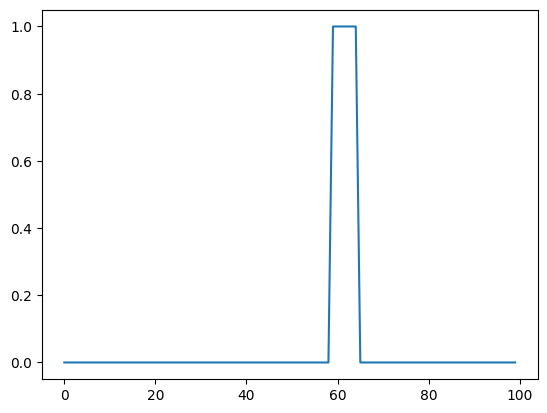

In [27]:
plt.plot(square_pulse)

In [28]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [29]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125,
       0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.   , 0.875,
       0.75 , 0.625, 0.5  , 0.375, 0.25 , 0.125, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

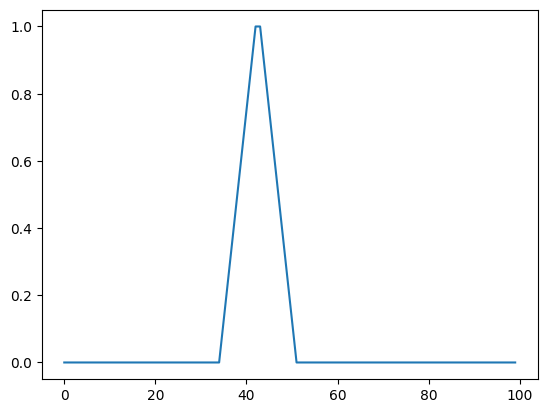

In [30]:
plt.plot(triangular_pulse)

In [47]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [48]:
np.newaxis == None

True

In [49]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [50]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.576
adam: Epoch 20 Loss 0.367
adam: Epoch 30 Loss 0.204
adam: Epoch 40 Loss 0.096
adam: Epoch 50 Loss 0.044
adam: Epoch 60 Loss 0.015
adam: Epoch 70 Loss 0.021
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

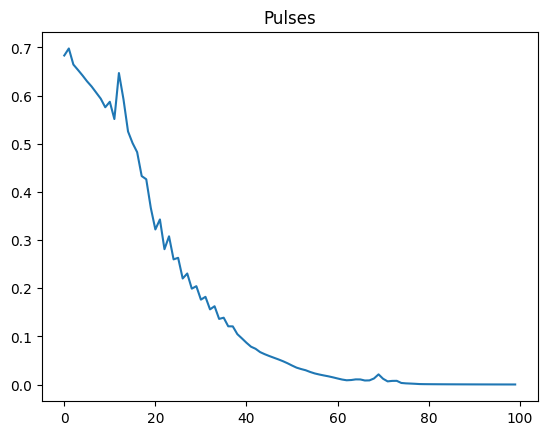

In [53]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [54]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.30


,square,triangular
square,98.6,1.4
triangular,0.0,100.0


torch.Size([10, 10])

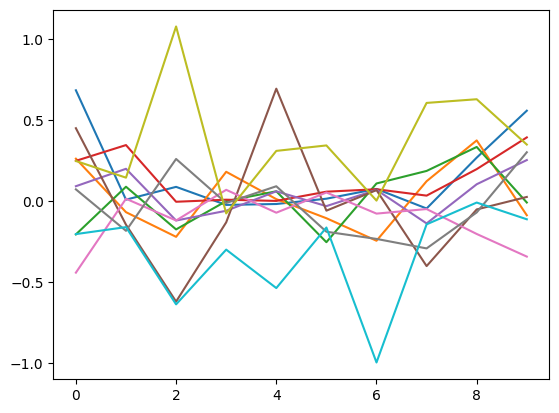

In [55]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [56]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

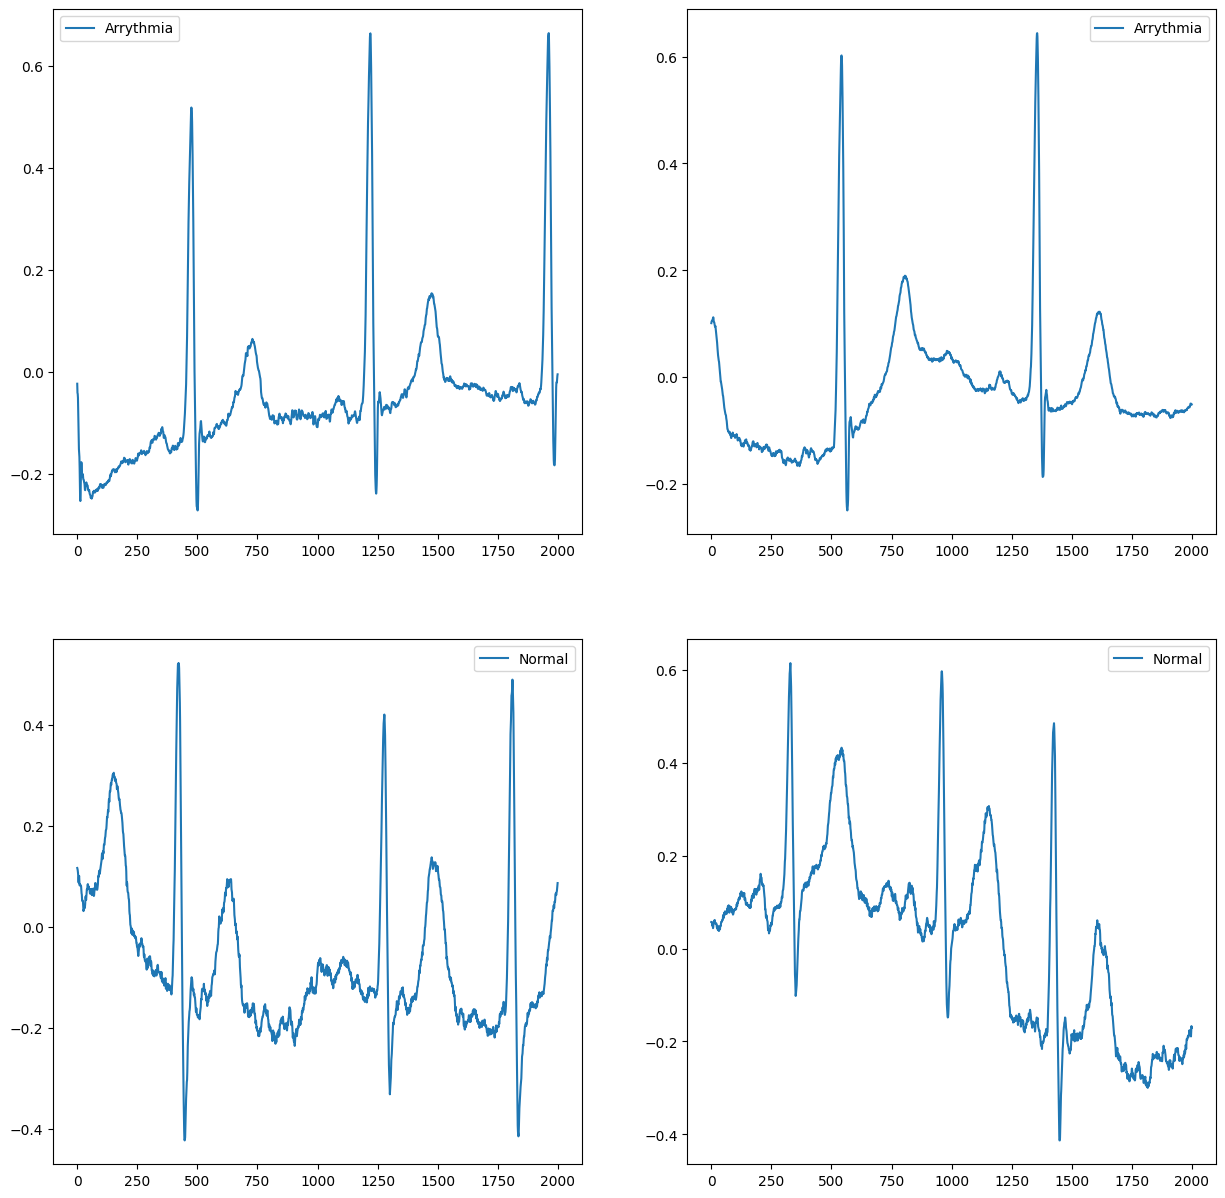

In [57]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [69]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [70]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['arr'],
       ['arr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [ ]:
result = []

In [ ]:
# Train CNN 1
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d1 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d1.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.309
adam: Epoch 20 Loss 0.151
adam: Epoch 30 Loss 0.083
adam: Epoch 40 Loss 0.086
adam: Epoch 50 Loss 0.063
adam: Epoch 60 Loss 0.049
adam: Epoch 70 Loss 0.051
adam: Epoch 80 Loss 0.025
adam: Epoch 90 Loss 0.058
adam: Epoch 100 Loss 0.025


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d1.use(Xtrain)
train_perc_correct1 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d1.use(Xtest)
test_perc_correct1 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct1:.2f}', "Percent Correct": f'{test_perc_correct1:.2f}'})

In [ ]:
# Train CNN 2
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [20, 5]

cnn1d2 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d2.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.571
adam: Epoch 20 Loss 0.404
adam: Epoch 30 Loss 0.278
adam: Epoch 40 Loss 0.195
adam: Epoch 50 Loss 0.151
adam: Epoch 60 Loss 0.124
adam: Epoch 70 Loss 0.128
adam: Epoch 80 Loss 0.107
adam: Epoch 90 Loss 0.078
adam: Epoch 100 Loss 0.083


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d2.use(Xtrain)
train_perc_correct2 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d2.use(Xtest)
test_perc_correct2 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct2:.2f}', "Percent Correct": f'{test_perc_correct2:.2f}'})

In [ ]:
# Train CNN 3
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d3 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d3.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d3.use(Xtrain)
train_perc_correct3 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d3.use(Xtest)
test_perc_correct3 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct3:.2f}', "Percent Correct": f'{test_perc_correct3:.2f}'})

In [ ]:
# Train CNN 4
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [2, 2]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d4 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d4.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.480
adam: Epoch 20 Loss 0.385
adam: Epoch 30 Loss 0.328
adam: Epoch 40 Loss 0.288
adam: Epoch 50 Loss 0.139
adam: Epoch 60 Loss 0.086
adam: Epoch 70 Loss 0.062
adam: Epoch 80 Loss 0.064
adam: Epoch 90 Loss 0.061
adam: Epoch 100 Loss 0.035


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d4.use(Xtrain)
train_perc_correct4 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d4.use(Xtest)
test_perc_correct4 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct4:.2f}', "Percent Correct": f'{test_perc_correct4:.2f}'})

In [ ]:
# Train CNN 5
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [2, 2]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [5, 2]

cnn1d5 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d5.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.642
adam: Epoch 20 Loss 0.609
adam: Epoch 30 Loss 0.590
adam: Epoch 40 Loss 0.567
adam: Epoch 50 Loss 0.549
adam: Epoch 60 Loss 0.523
adam: Epoch 70 Loss 0.502
adam: Epoch 80 Loss 0.471
adam: Epoch 90 Loss 0.445
adam: Epoch 100 Loss 0.403


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d5.use(Xtrain)
train_perc_correct5 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d5.use(Xtest)
test_perc_correct5 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct5:.2f}', "Percent Correct": f'{test_perc_correct5:.2f}'})

In [ ]:
# CNN 6
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d6 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d6.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.454
adam: Epoch 20 Loss 0.329
adam: Epoch 30 Loss 0.260
adam: Epoch 40 Loss 0.207
adam: Epoch 50 Loss 0.178
adam: Epoch 60 Loss 0.147
adam: Epoch 70 Loss 0.133
adam: Epoch 80 Loss 0.110
adam: Epoch 90 Loss 0.108
adam: Epoch 100 Loss 0.093


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d6.use(Xtrain)
train_perc_correct6 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d6.use(Xtest)
test_perc_correct6 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct6:.2f}', "Percent Correct": f'{test_perc_correct6:.2f}'})

In [ ]:
# Train CNN 7
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [20, 5]

cnn1d7 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d7.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.620
adam: Epoch 20 Loss 0.539
adam: Epoch 30 Loss 0.485
adam: Epoch 40 Loss 0.449
adam: Epoch 50 Loss 0.420
adam: Epoch 60 Loss 0.393
adam: Epoch 70 Loss 0.369
adam: Epoch 80 Loss 0.349
adam: Epoch 90 Loss 0.336
adam: Epoch 100 Loss 0.323


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d7.use(Xtrain)
train_perc_correct7 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d7.use(Xtest)
test_perc_correct7 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct7:.2f}', "Percent Correct": f'{test_perc_correct7:.2f}'})

In [ ]:
# CNN 8
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d8 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d8.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.354
adam: Epoch 20 Loss 0.280
adam: Epoch 30 Loss 0.223
adam: Epoch 40 Loss 0.175
adam: Epoch 50 Loss 0.155
adam: Epoch 60 Loss 0.188
adam: Epoch 70 Loss 0.141
adam: Epoch 80 Loss 0.112
adam: Epoch 90 Loss 0.115
adam: Epoch 100 Loss 0.086


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d8.use(Xtrain)
train_perc_correct8 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d8.use(Xtest)
test_perc_correct8 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct8:.2f}', "Percent Correct": f'{test_perc_correct8:.2f}'})

In [ ]:
# Train CNN 9
n_hiddens_per_conv_layer = [10, 20]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d9 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d9.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.291
adam: Epoch 20 Loss 0.121
adam: Epoch 30 Loss 0.073
adam: Epoch 40 Loss 0.033
adam: Epoch 50 Loss 0.022
adam: Epoch 60 Loss 0.030
adam: Epoch 70 Loss 0.027
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.022
adam: Epoch 100 Loss 0.042


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d9.use(Xtrain)
train_perc_correct9 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d9.use(Xtest)
test_perc_correct9 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct9:.2f}', "Percent Correct": f'{test_perc_correct9:.2f}'})

In [ ]:
# CNN 10
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [20, 20]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d0 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d0.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.327
adam: Epoch 20 Loss 0.168
adam: Epoch 30 Loss 0.130
adam: Epoch 40 Loss 0.109
adam: Epoch 50 Loss 0.125
adam: Epoch 60 Loss 0.093
adam: Epoch 70 Loss 0.064
adam: Epoch 80 Loss 0.074
adam: Epoch 90 Loss 0.070
adam: Epoch 100 Loss 0.073


In [ ]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d0.use(Xtrain)
train_perc_correct0 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d0.use(Xtest)
test_perc_correct0 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct0:.2f}', "Percent Correct": f'{test_perc_correct0:.2f}'})

In [126]:
df = pandas.DataFrame(result, columns=['Hiddens / Layer', "Hiddens / FC Layer", "Patch Size / Conv Layer", "Stride / Conv Layer", 'Percent Correct'])
df

,Hiddens / Layer,Hiddens / FC Layer,Patch Size / Conv Layer,Stride / Conv Layer,Percent Correct
0,"[5, 10]","[10, 10]","[100, 20]","[20, 5]",85.49
1,"[5, 10]","[10, 10]","[50, 10]","[5, 2]",76.83
2,"[5, 10]","[10, 10]","[100, 20]","[5, 2]",84.01
3,"[5, 10]","[2, 2]","[100, 20]","[20, 5]",89.04
4,"[5, 10]","[2, 2]","[50, 10]","[5, 2]",77.49
5,"[2, 5]","[10, 10]","[100, 20]","[20, 5]",87.47
6,"[2, 5]","[10, 10]","[50, 10]","[20, 5]",65.38
7,"[5, 10]","[20, 20]","[100, 20]","[5, 2]",82.11
8,"[2, 5]","[10, 10]","[100, 20]","[5, 2]",76.75
9,"[10, 20]","[10, 10]","[100, 20]","[20, 5]",89.53


The network structure and training parameters that produced the best results was the network with Hiddens / Layer: [10, 20], Hiddens / FC Layer: [10, 10], Patch Size: [100, 20], Stride: [20, 5] with a test accuracy of 89.53%. The larger number of Hiddens / Layer allows for a better capacity to learn patterns, and the Hiddens / FC Layer is sufficient to form a general representation of the data while being specific enough to actually learn something.

A close second was the network the same as above but with Hiddens / FC Layer: [2, 2], with 89.04%. This may be due to the low number of fully connected neurons and the large patch sizes/strides acted as a bottleneck in the network, forcing very generalized representations of the data. This may have resulted in a better transitions between training data and test data, and therefore higher test accuracy. The higher number of Hiddens / Layer resulted in a slight increase in the accuracy, but nothing significant.

Overall, a larger patch size resulted in higher accuracy. This is likely because a smaller patch size can't capture features as effectively as larger patch sizes. Strides seems to have a much lower impact on the overall accuracy, with a lower stride resulting in slightly lower accuracy. This could be due to such a low stride resulting in overfitting to the train data.

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [67]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Tone-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.us

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.